In [1]:
import numpy as np

In [2]:
N=20
T=0.3
epsilon=1  #epsilon = 0.1 makes the interaction very weak: small dE: high acceptance. With epsilon = 1.0, the energy sensitivity increases and the acceptance rate becomes more realistic.
amp = 0.6          # a sensible starting point
target_low = 0.3
target_high = 0.6
block = N*N    

In [3]:
def init_grid(N,seed=0):
    np.random.seed(seed)
    theta= np.random.rand(N,N)*2*np.pi
    return theta

In [4]:
def neighbours(i,j):
    nbrs=[((i-1)%N,j) , ((i+1)%N,j) , (i,(j+1)%N) , (i,(j-1)%N) ]
    return nbrs

In [5]:
def pair_energy(theta_i,theta_j):
    delta= theta_i - theta_j
    cosd= np.cos(delta)
    P2= 0.5*(3*cosd**2-1)
    return -epsilon*P2

In [6]:
def local_energy(theta,i,j):
    E=0
    for (ii,jj) in neighbours(i,j):
        E += pair_energy(theta[i,j],theta[ii,jj])
    return E

In [7]:
def whole_energy(theta):
    E=0
    for i in range(N):
        for j in range(N):
            E += local_energy(theta,i,j)
    return 0.5*E
            

In [8]:
def metropolis_step(theta,T,amp):
    i= np.random.randint(N)
    j= np.random.randint(N)
    old = local_energy(theta, i, j)
    old_angle= theta[i,j].copy()
    dtheta = (np.random.rand() - 0.5) * amp # amplitude : adjustable that determines the step size.
    theta[i,j] = (theta[i,j] + dtheta) % (2*np.pi)
    new = local_energy(theta, i, j)
    dE = new - old
    if dE <= 0 or np.random.rand() < np.exp(-dE / T):
        return dE,True # accepted
    else:
        theta[i,j] = old_angle
        return 0.0 , False

In [9]:
def order_parameter(theta):
    c2 = np.cos(2*theta).mean()
    s2 = np.sin(2*theta).mean()
    S = np.sqrt(c2**2 + s2**2)
    return S
    

if __name__ == "__main__":   #This section automatically runs a simple test simulation only when you run the file directly, not when you import it.
    N = 20
    theta = init_grid(N, seed=42)
    dE = metropolis_step(theta, T=1.0)
    print("S =", order_parameter(theta))


In [10]:
theta = init_grid(N,seed=0)

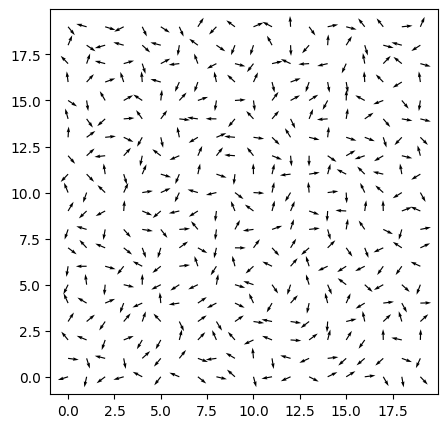

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
x_pos, y_pos = np.meshgrid(np.arange(N), np.arange(N))
x_direct = np.cos(theta)
y_direct = np.sin(theta)
plt.quiver(x_pos, y_pos, x_direct, y_direct )

In [12]:
theta.shape

(20, 20)

In [13]:
E_total=whole_energy(theta)
E_total

-180.66503470948152

In [14]:
equilibrium_steps = 600000
production_steps = 400000

In [15]:
accepted = 0
attempts = 0

In [16]:
Energy= [E_total]
for step in range(equilibrium_steps): 
    dE, acc= metropolis_step(theta,T,amp)
    if acc:
       E_total= E_total+dE
       Energy.append(E_total)
       accepted += 1
    attempts += 1
    if (step+1) % block == 0:          
        rate = accepted / attempts
        if rate > target_high:         # The step is too small.
            amp *= 1.5                 
        elif rate < target_low:        # The step is too large.
            amp *= 0.7                 
        accepted = 0
        attempts = 0               # resetا
# Production: amp is fix.

Energy_total= Energy[-1]

In [17]:
accepted = 0
attempts = 0
sweep = N * N

In [18]:
S_values = []
Energy_pr=[]
Accepted_cum = []   # "The actual x-axis for ‘Accepted moves’."
Step_cum = []       # "The x-axis for ‘Total MC steps’."

In [19]:
from tqdm import trange

In [20]:
for step in trange(production_steps):
    T= 0.3
    dE, acc = metropolis_step(theta, T,amp)
    attempts +=1
    if acc:
        Energy_total= Energy_total+ dE
        accepted += 1
    if (step+1) % sweep == 0:
        S_values . append(order_parameter(theta))
        Energy_pr.append(Energy_total)
        Accepted_cum.append(accepted)      # Cumulative,acc     step: 1, 0, 1, 1, 0, 1          cum:      1, 1, 2, 3, 3, 4 #How many moves have been accepted up to this point?
        Step_cum.append(step + 1)          #How many MC steps have we taken up to this point?"
accepted_rate= accepted/attempts 
print("acceptance: ", accepted_rate) #30% - 60% is ok, if it is fewer:we decrease the angle , if it is a lot: we choose bigger angle
Energy_pr = np.array(Energy_pr)
    

100%|███████████████████████████████████████████████████████████████████████| 400000/400000 [00:31<00:00, 12679.26it/s]

acceptance:  0.3681175


In [21]:
print(Accepted_cum[0:10]) 
print(Step_cum[0:10])

[158, 294, 436, 574, 725, 863, 993, 1136, 1271, 1424]
[400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000]


Text(0, 0.5, 'Energy')

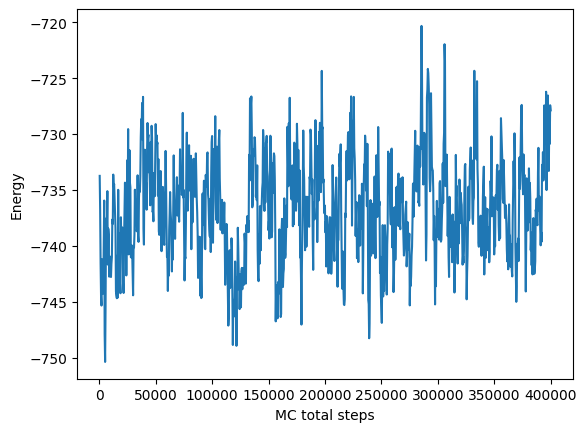

In [22]:
# Energy vs total MC steps
plt.plot(Step_cum, Energy_pr)
plt.xlabel("MC total steps")
plt.ylabel("Energy")


Text(0, 0.5, 'Energy')

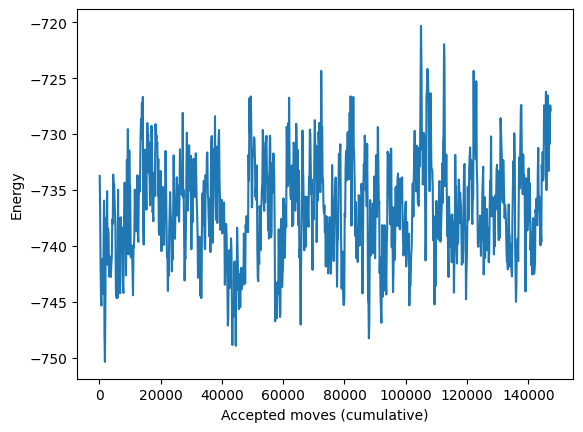

In [23]:
# Energy vs accepted moves
plt.plot(Accepted_cum, Energy_pr)
plt.xlabel("Accepted moves (cumulative)")
plt.ylabel("Energy")


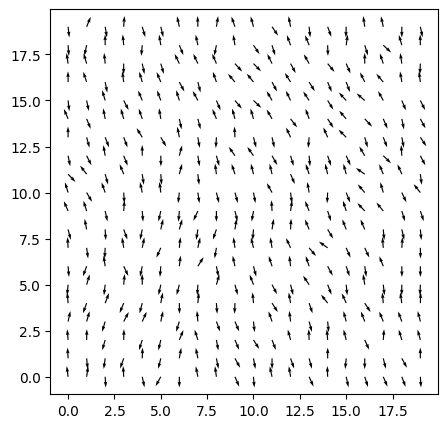

In [24]:
plt.figure(figsize=(5,5))
x_pos, y_pos = np.meshgrid(np.arange(N), np.arange(N))
x_direct = np.cos(theta)
y_direct = np.sin(theta)
plt.quiver(x_pos, y_pos, x_direct, y_direct )

In [25]:
S_values[-1]



0.8569825845768466

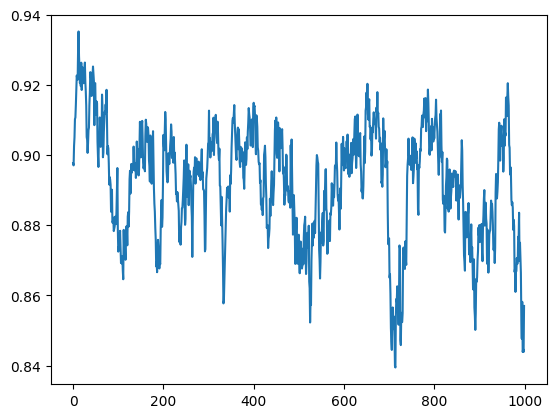

In [26]:
plt.plot(S_values)

In [27]:
def simulate_at_T(T, N, equil_sweeps, prod_sweeps, seed=0):

    np.random.seed(seed)
    theta = init_grid(N, seed=seed)
    E_total = whole_energy(theta)

    target_low, target_high = 0.30, 0.45
    amp = 0.8
    acc = 0; att = 0
    AMP_MIN = 0.05
    AMP_MAX = 5*np.pi/4

    # Equilibration
    for step in trange(equil_sweeps * N * N, desc=f"Equil T={T}", leave=False):
        dE, accepted = metropolis_step(theta, T, amp)
        att += 1
        if accepted:
            E_total += dE
            acc += 1

        if (step + 1) % (N * N) == 0:
            rate = acc / max(att, 1)

            if step < (equil_sweeps * N * N // 2):
                if rate > target_high: amp *= 1.2
                elif rate < target_low: amp *= 0.8
            else:
                if rate > target_high: amp = min(AMP_MAX, amp * 1.1)
                elif rate < target_low: amp = max(AMP_MIN, amp * 0.9)

            acc = 0; att = 0
    acc_rate_equil = rate

    acc = 0; att = 0
    if acc_rate_equil > 0.6:
        sample_every = 3 * N * N
    elif acc_rate_equil > 0.5:
        sample_every = 2 * N * N
    else:
        sample_every = 1 * N * N #base on rate we order the distances between sampling , we refuse Decorrelated Sampling

    # Production
   
    S_samples = []
    Energy_samples = []
    for step in trange(prod_sweeps * N * N, desc=f"Prod T={T}", leave=False):
        dE, accepted = metropolis_step(theta, T, amp)
        att += 1
        if accepted:
            E_total += dE
            acc += 1

        if (step + 1) % sample_every == 0:
            S_samples.append(order_parameter(theta))
            Energy_samples.append(E_total)

    acc_rate = acc / max(att, 1)
    
        
        
    # Statistics 
    S_samples = np.array(S_samples)
    E_arr = np.array(Energy_samples)
    
    S_mean = np.mean(S_samples)
    varS = np.var(S_samples, ddof=1)
    chi = (N*N) * varS / T

    varE = np.var(Energy_samples, ddof=1)
    capacity = varE / ( (N*N) * T*T )

    S_sem = S_samples.std(ddof=1) / np.sqrt(len(S_samples))

    return S_mean, S_sem, acc_rate, amp, chi, capacity, S_samples, Energy_samples


In [28]:
T_list = [ 0.1, 0.2,0.3,0.4,0.5,0.6,0.65, 0.68, 0.70, 0.72, 0.75, 0.78, 0.80, 0.82, 0.85, 0.88, 0.90, 0.92, 0.95,1, 1.1, 1.5, 2.0]
S_means, S_errs, acc_rates, amps,chis,capacities = [], [], [], [],[],[]
results_S = {}
results_E = {}

results_S = {}
results_E = {}

for T in T_list:
    if T < 0.5:
        args = dict(N=N, equil_sweeps=1500, prod_sweeps=800, seed=42)
    elif 0.5 <= T < 1:
        args = dict(N=N, equil_sweeps=2000, prod_sweeps=2000, seed=42)
    else:
        args = dict(N=N, equil_sweeps=500, prod_sweeps=800, seed=42)

    S_mean, S_err, acc_rate, amp_final, chi, capacity, S_samples, Energy_samples = simulate_at_T(T, **args)

    S_means.append(S_mean); S_errs.append(S_err)
    acc_rates.append(acc_rate); amps.append(amp_final)
    chis.append(chi), capacities.append(capacity)
    results_S[T] = S_samples
    results_E[T] = Energy_samples

    print(f"T={T:>4}: S={S_mean:.3f} ± {S_err:.3f} | acc={acc_rate:.3f} | amp={amp_final:.3f}")



T= 0.1: S=0.965 ± 0.000 | acc=0.369 | amp=0.790


T= 0.2: S=0.922 ± 0.001 | acc=0.371 | amp=1.127


T= 0.3: S=0.891 ± 0.001 | acc=0.396 | amp=1.312


T= 0.4: S=0.855 ± 0.001 | acc=0.405 | amp=1.506


T= 0.5: S=0.805 ± 0.001 | acc=0.380 | amp=1.851


T= 0.6: S=0.752 ± 0.001 | acc=0.374 | amp=2.133


T=0.65: S=0.728 ± 0.001 | acc=0.361 | amp=2.362


T=0.68: S=0.695 ± 0.001 | acc=0.379 | amp=2.322


T= 0.7: S=0.694 ± 0.001 | acc=0.375 | amp=2.404


T=0.72: S=0.636 ± 0.002 | acc=0.372 | amp=2.520


T=0.75: S=0.617 ± 0.002 | acc=0.366 | amp=2.680


T=0.78: S=0.558 ± 0.002 | acc=0.393 | amp=2.610


T= 0.8: S=0.524 ± 0.002 | acc=0.387 | amp=2.751


T=0.82: S=0.451 ± 0.003 | acc=0.383 | amp=2.920


T=0.85: S=0.426 ± 0.003 | acc=0.369 | amp=3.284


T=0.88: S=0.319 ± 0.003 | acc=0.350 | amp=3.927


T= 0.9: S=0.306 ± 0.003 | acc=0.364 | amp=3.849


T=0.92: S=0.325 ± 0.003 | acc=0.374 | amp=3.849


T=0.95: S=0.215 ± 0.002 | acc=0.411 | amp=3.534


T=   1: S=0.189 ± 0.003 | acc=0.413 | amp=3.927


T= 1.1: S=0.154 ± 0.003 | acc=0.461 | amp=3.927


T= 1.5: S=0.091 ± 0.003 | acc=0.602 | amp=3.927


T= 2.0: S=0.077 ± 0.003 | acc=0.700 | amp=3.927


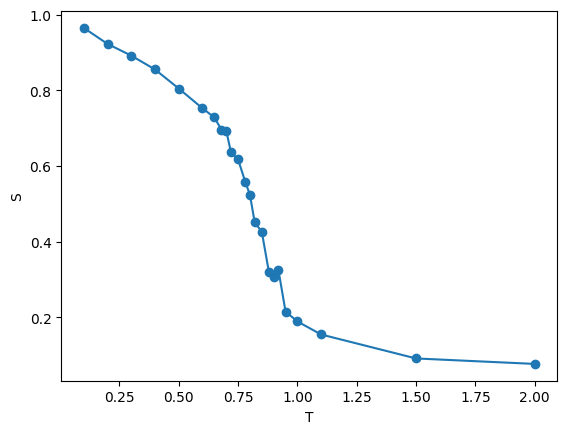

In [29]:
plt.plot(T_list,S_means, '-o'); plt.xlabel('T'); plt.ylabel('S'); plt.show()


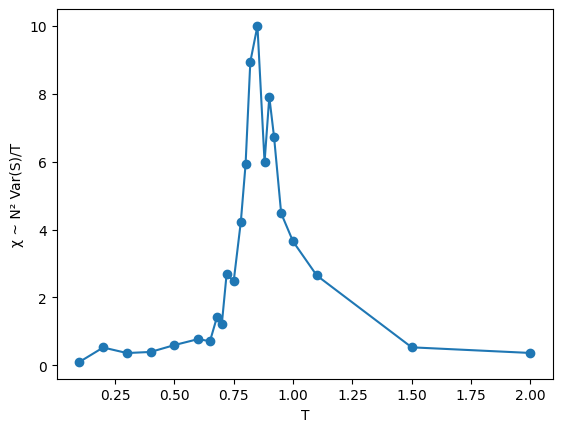

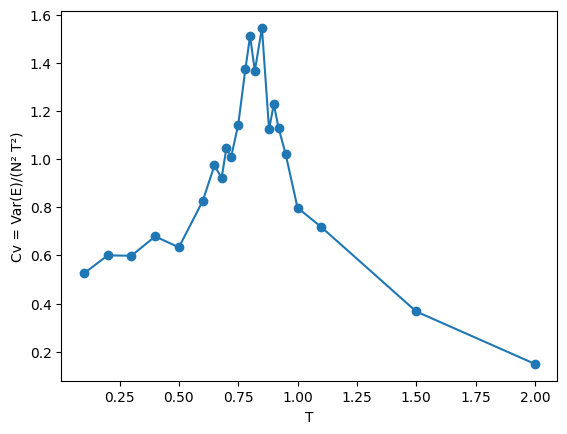

In [30]:
plt.plot(T_list, chis, '-o'); plt.xlabel('T'); plt.ylabel('χ ~ N² Var(S)/T'); plt.show()
plt.plot(T_list, capacities,  '-o'); plt.xlabel('T'); plt.ylabel('Cv = Var(E)/(N² T²)'); plt.show()

In [31]:
Tc_chi = T_list[int(np.argmax(chis))]
Tc_cv  = T_list[int(np.argmax(capacities))]
Tc_est = 0.5*(Tc_chi + Tc_cv)
print("Tc_chi =", Tc_chi, " Tc_cv =", Tc_cv, "  -> Tc ≈", Tc_est)

Tc_chi = 0.85  Tc_cv = 0.85   -> Tc ≈ 0.85


In [32]:
def quad_peak_T(T, Y):
    k = int(np.argmax(Y))
    i0 = max(0, k-2); i1 = min(len(T), k+3)
    t = np.array(T[i0:i1]); y = np.array(Y[i0:i1])
    a,b,c = np.polyfit(t, y, 2)   # y ≈ aT² + bT + c
    T_peak = -b/(2*a)
    return T_peak


In [33]:
Tc_chi_fit = quad_peak_T(T_list, chis)
Tc_cv_fit  = quad_peak_T(T_list, capacities)
print("Tc (χ-fit) =", Tc_chi_fit, "  Tc (Cv-fit) =", Tc_cv_fit)

Tc (χ-fit) = 0.8508187353503741   Tc (Cv-fit) = 0.7889073623492286


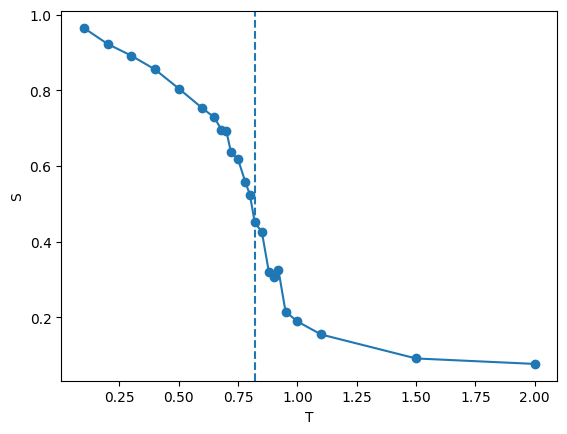

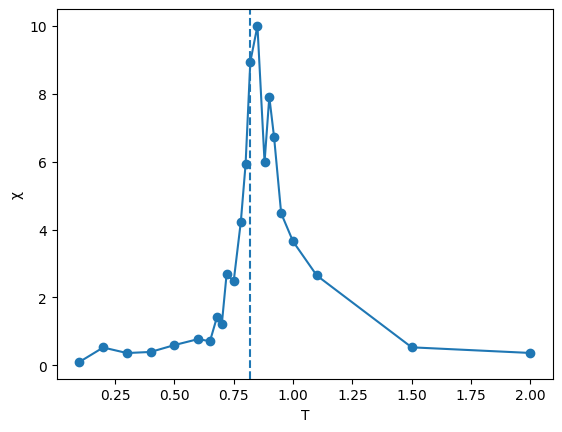

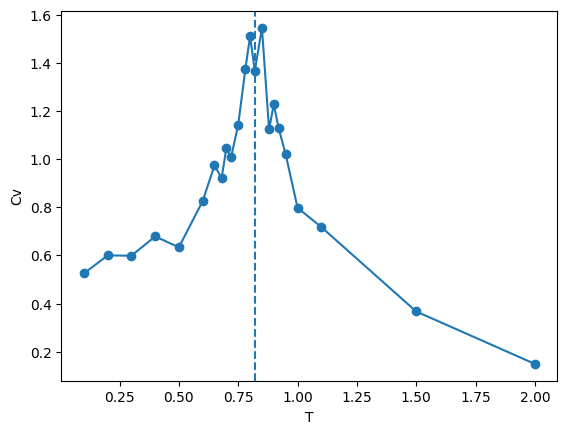

In [34]:
Tc = 0.82
for ylab, Y in [('S', S_means), ('χ', chis), ('Cv', capacities)]:
    plt.plot(T_list, Y, '-o')
    plt.axvline(Tc, linestyle='--')
    plt.xlabel('T'); plt.ylabel(ylab); plt.show()


estimating the nematic–isotropic phase transition temperature Tc using the
peak positions of the susceptibility χ(T) and the heat capacity Cv(T),
For N = 20, both χ and Cv show a clear maximum around 
## Tc ≈ 0.82.
Finite-size scaling with larger lattices (N = 30, 40, …) can be used to obtain
a more accurate, size-independent Tc in the thermodynamic limit.

How to reduce the discrepancy (optional polishing) Increase the temperature resolution near the peaks. Add one point every 0.01 in the range 0.78–0.88.
Perform more sampling in the transition region.